## Measurement vs. Magic Phase Diagrams for Clifford Brickwork Circuits
This notebook uses Quimb to simulate a brickwork circuit of random Clifford gates on a 1D chain of qubits. At each layer of the circuit, single-qubit $T$ gates are implemented with some probability $p_T$, and single-qubit Z-basis measurements are implemented with some probability $p_M$. Inverse Participation Ratio (IPR) and Participation Entropy (S) are calculated as measures of state delocalization and compared for different measurement and $T$ gate probabilities.

In [56]:
%config InlineBackend.figure_formats = ['svg']
from quimb.tensor import *
from quimb import *
from quimb.gates import *
import numpy as np
import random
import quimb as qu
import quimb.tensor as qtn
import matplotlib.pyplot as plt
from qiskit.quantum_info import random_clifford
from tqdm import tqdm
from quimb.tensor.tensor_1d_compress import tensor_network_1d_compress_zipup as zipup
import itertools
import matplotlib.colors as mcolors

#### Choose parameters
Note that L>14 may lead to extremely high computation time. Measurement and T-gate probabilities both scale poorly.

In [ ]:
L = 6                 # number of qubits
D = 18                # number of layers
n_runs = 10            # number of independent circuit realizations to average over
p_M = [0, 0.5, 1]  # measurement probability per qubit per layer, will compare all probs in list
p_T = [0, 0.5, 1]             # probability of T-gate doping
colors = itertools.cycle(list(mcolors.CSS4_COLORS.keys()))
rng = np.random.default_rng(None) # random float in [0, 1), replace None with seed (1234) for reproducability

#### Function definitions

For a normalized state vector, we calculate the IPR as follows:
$$
|\psi\rangle = \sum_i c_i |i\rangle, \qquad \mathrm{IPR} = \sum_i |c_i|^4
$$

The participation entropy is defined as:
$$
S_\alpha = \frac{1}{1 - \alpha} \log \left( \sum_i |c_i|^{2\alpha} \right),
$$
where $\alpha$ is the Rényi index and $\alpha = 2$ corresponds to the IPR. This gives $S_2 = -\log(\mathrm{IPR})$.

The n-qubit Clifford group is the normalizer of the n-qubit Pauli group (they map Pauli operators onto Pauli operators). Clifford gates can be efficiently classically simulated, and Clifford + $T$ is a universal gate set.

The $T$ gate is defined as:
$$
T = \begin{bmatrix}
1 & 0 \\
0 & e^{i\pi/4}
\end{bmatrix}
$$

Injecting $T$ gates into our circuit simulation is equivalent to injecting magic because in a quantum circuit, each $T$ gate is implemented by consuming an ancilla in the magic state, $|A\rangle = \tfrac{1}{\sqrt{2}}\left( |0\rangle + e^{i\pi/4} |1\rangle \right)$.

Note: "$T$ gates tend to increase the stabilizer rank of the time-evolved state, while monitors tend to decrease it by projecting single qubits onto a stabilizer state." [(Bejan et al.)](https://arxiv.org/pdf/2312.00132)

In [45]:
def ipr_4(state):
    # calculate IPR via, takes circ
    psi = state.psi
    ipr_tn = (psi.H & psi & psi.H & psi)
    # 4-copy contraction
    ipr_val = ipr_tn.contract(output_inds=())
    return float(ipr_val)
def ipr(state):
    # calculate IPR from dense statevector, takes circ
    dense = state.psi.to_dense()
    dense = dense / np.linalg.norm(dense)
    return np.sum(np.abs(dense) ** 4)
def pentropy(ipr):
    # calculate participation entropy from IPR
    return -np.log(ipr)
def T():
    # Return single-qubit T gate matrix.
    return np.array([[1, 0],
                     [0, np.exp(1j * np.pi / 4)]], dtype=complex)
def RC():
    # Get a random 2-qubit Clifford from Qiskit to matrix
    return random_clifford(2).to_matrix()

In [46]:
def z_measure(circ, L, pM, rng, round_int):
    """
    Apply Z-basis measurements to each qubit in a circuit with probability pM.
    """
    dense = circ.psi.to_dense()
    outcomes = {}

    for q in range(L):
        if rng.random() < pM:
            Z = qu.pauli('Z')
            A = qu.ikron(Z, [2] * L, q)          # Z acting on qubit q
            result, dense = qu.measure(dense, A) # collapses + renormalizes
            outcomes[q] = result
            # optional: tag circuit with measurement event
            # circ.add_tag(f"MEAS_q{q}_layer{layer_idx}") (need to fix this)
    
    state = qtn.MatrixProductState.from_dense(dense)
    #print(np.linalg.norm(dense)) (for debugging)

    return state, outcomes


#### Main call for IPR and Participation Entropy vs. time plots

In [47]:
iprs_avg_dict = {} # to store averaged IPRs for each prob since they get overwritten in loop
entropies_avg_dict = {} # "" for entropies
circuits = {} # save circuits to draw

combos = [(pM, pT) for pM in p_M for pT in p_T]
for (pM, pT), color in zip(combos, colors): # loop over T-gate probs
    iprs_avg = np.zeros(D + 1) # initialize IPRs for 0th + D layers
    entropies_avg = np.zeros(D + 1)
    for run in tqdm(range(n_runs), desc=f"Running pM={pM}, pT={pT}", leave=True, ncols=80): # loop over n runs
        circ = qtn.CircuitMPS(N=L, max_bond=1024, cutoff=1e-3) #initialize circuit of length L at start of each run, default all in 0
        iprs = [] # to store ipr at each layer
        entropies = [] # to store each participation entropy
        # psi0 = circ.psi # initial state; circ is circuit, psi is tensor network state, to_dense gives single statevector (note this is expensive)
        ipr0 = ipr(circ) # should be 1
        iprs.append(ipr0)
        entropies.append(pentropy(ipr0)) 

        for r in range(D): # for each layer in depth
            if r % 2 == 0: 
                # at even layers apply random 2-site Clifford
                for i in range(0, L - 1, 2):
                    U = RC()
                    circ.apply_gate(U, i, i + 1, gate_round=r) # pairs (0,1), (2,3), ...
            else:
                for i in range(1, L - 1, 2):
                # at odd layers apply random 2-site Clifford
                    U = RC()
                    circ.apply_gate(U, i, i + 1, gate_round=r) # pairs (1,2), (3,4), ...
            
            for q in range(L): # for each qubit, add T gate with prob pT
                if np.random.rand() < pT:
                    circ.apply_gate(T(), q, gate_round=r, tags=("T",))
            
            state, outcomes = z_measure(circ, L, pM, rng, round_int=r)
            circ = qtn.CircuitMPS(N=L, psi0=state, max_bond=1024, cutoff=1e-3)

            # attemps at implementing Z-measurements
            #outcomes = z_measure(circ, L, pM, rng, round_int=r) #after each layer, measure with prob p
            #_ = z_measure_subset(circ, qs_all=range(L), pM=pM, round_int=r)
            #outcomes = random_measurement_round(circ, L=L, p=pM, round_int=r)

            ipr_n=ipr(circ)
            iprs.append(ipr_n) # record IPR after each layer and measurement
            entropies.append(pentropy(ipr_n))
        iprs_avg += np.array(iprs) # summing IPR at each layer for each run
        entropies_avg += np.array(entropies)

    iprs_avg /= n_runs # average the array of IPRs over runs
    iprs_avg_dict[(pM, pT)] = iprs_avg  # store avg IPRs with corresponding probability to plot
    entropies_avg /= n_runs
    entropies_avg_dict[(pM, pT)] = entropies_avg
    circuits[(pM, pT)] = circ

Running pM=1, pT=1: 100%|███████████████████████| 10/10 [02:44<00:00, 16.46s/it]


#### Plots

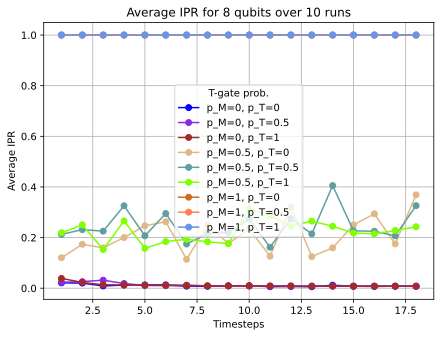

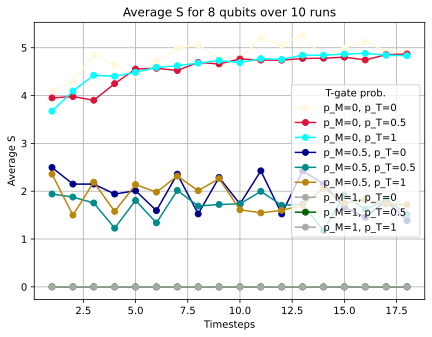

In [48]:
# Plot IPR
plt.figure(figsize=(7, 5))
for (pM, pT), color in zip(combos, colors):
    xi = range(1, D + 1)
    yi = iprs_avg_dict[(pM, pT)][1:]  # skip t=0
    plt.plot(xi, yi, marker='o', color=color, label=f"p_M={pM}, p_T={pT}")

#plt.yscale('log')
plt.xlabel("Timesteps")
plt.ylabel("Average IPR")
plt.title(f"Average IPR for {L} qubits over {n_runs} runs")
plt.grid(True)
plt.legend(title="T-gate prob.")
plt.show()

# Plot S
plt.figure(figsize=(7, 5))
for (pM, pT), color in zip(combos, colors):
    xs = range(1, D + 1)
    ys = entropies_avg_dict[(pM, pT)][1:]  # skip t=0
    plt.plot(xs, ys, marker='o', color=color, label=f"p_M={pM}, p_T={pT}")

#plt.yscale('log')
plt.xlabel("Timesteps")
plt.ylabel("Average S")
plt.title(f"Average S for {L} qubits over {n_runs} runs")
plt.grid(True)
plt.legend(title="T-gate prob.")
plt.show()

#### IPR value comparison

"The smallest value of the IPR corresponds to a fully delocalized state, $\psi(x) = 1/\sqrt{N}$ for a system of size $N$, where the IPR yields

$$
\sum_x |\psi(x)|^4 = \frac{N}{(N^{1/2})^4} = \frac{1}{N}.
$$

Values of the IPR close to 1 correspond to localized states (pure states in the analogy), as can be seen with the perfectly localized state $\psi(x) = \delta_{x, x_0}$, where the IPR yields

$$
\sum_x |\psi(x)|^4 = 1.
$$

In one dimension, IPR is directly proportional to the inverse of the localization length, i.e., the size of the region over which a state is localized [(Wikipedia)](https://en.wikipedia.org/wiki/Purity_(quantum_mechanics)#Inverse_Participation_Ratio_(IPR))."

For $L$ number of qubits, we have the following values:

Haar-average IPR ($q=2$):
$$I_2^{\mathrm{Haar}} = \frac{2}{d^L \left(d^L + 1\right)}$$

Max participation Entropy:
$$S_2^{\mathrm{max}} = L \ln 2.$$

Haar-average participation entropy ($q=2$):
$$S_2^{\mathrm{Haar}} = \ln\!\left(d^L + 1\right) - \ln 2$$

[(Source)](http://arxiv.org/abs/2404.10725)

In [49]:
# print stats for each measurement/T-gate prob combo
N = 2 ** L  # Hilbert space dimension
haar_avg_ipr = 2 / (N + 1)  # Average IPR of a Haar-random state for reference

for (pM, pT), iprs_avg in iprs_avg_dict.items():
    # start looking for min and avg IPR after 10 layers
    min_ipr = np.min(iprs_avg[11:])
    avg_ipr_after_t10 = np.mean(iprs_avg[11:])

    print(f"\nResults for pM={pM}, pT={pT}:")
    print(f"  Minimum IPR (t > 10): {min_ipr:.6g}")
    print(f"  Average IPR (t > 10): {avg_ipr_after_t10:.6g}")
    print(f"  Haar average IPR for L={L}: {haar_avg_ipr:.6g}")


Results for pM=0, pT=0:
  Minimum IPR (t > 10): 0.00585938
  Average IPR (t > 10): 0.00771484
  Haar average IPR for L=8: 0.0077821

Results for pM=0, pT=0.5:
  Minimum IPR (t > 10): 0.00769012
  Average IPR (t > 10): 0.00838257
  Haar average IPR for L=8: 0.0077821

Results for pM=0, pT=1:
  Minimum IPR (t > 10): 0.00759761
  Average IPR (t > 10): 0.00801971
  Haar average IPR for L=8: 0.0077821

Results for pM=0.5, pT=0:
  Minimum IPR (t > 10): 0.125
  Average IPR (t > 10): 0.227539
  Haar average IPR for L=8: 0.0077821

Results for pM=0.5, pT=0.5:
  Minimum IPR (t > 10): 0.161845
  Average IPR (t > 10): 0.25514
  Haar average IPR for L=8: 0.0077821

Results for pM=0.5, pT=1:
  Minimum IPR (t > 10): 0.214874
  Average IPR (t > 10): 0.243045
  Haar average IPR for L=8: 0.0077821

Results for pM=1, pT=0:
  Minimum IPR (t > 10): 1
  Average IPR (t > 10): 1
  Haar average IPR for L=8: 0.0077821

Results for pM=1, pT=0.5:
  Minimum IPR (t > 10): 1
  Average IPR (t > 10): 1
  Haar average

#### Circuit drawings

In [57]:
# (need to fix)
#for p, circ in circuits.items():
    # draw whole circuit with T-gates highlighted
    #circ.draw()
circ.draw()

(<Figure size 0x133.333 with 1 Axes>, <Axes: >)

/Users/gemmashay/Desktop/Thesis/thesisenv/lib/python3.13/site-packages/matplotlib/axes/_base.py:2005: RuntimeWarning: divide by zero encountered in scalar divide
  fig_aspect = bb.height / bb.width


ValueError: 'bboxes' cannot be empty

<Figure size 0x133.333 with 1 Axes>

#### Phase diagram of final IPR vs. measurement and T-gate probabilities

In [51]:
p_M = np.linspace(0, 1, 21)   # [0.0, 0.05, 0.1, ..., 1.0]
p_T = np.linspace(0, 1, 21)
n_runs = 1

iprs_final_dict = {}   # to store only final IPR
circuits = {}          # save circuits to draw

combos = [(pM, pT) for pM in p_M for pT in p_T]
for (pM, pT), color in zip(combos, colors):  # loop over combos
    final_iprs = []
    for run in tqdm(range(n_runs), desc=f"Running pM={pM}, pT={pT}", leave=True, ncols=80):
        circ = qtn.CircuitMPS(N=L, max_bond=512, cutoff=1e-6)  # initialize circuit of length L

        # initial IPR should be 1, no need to store

        for r in range(D):  # for each layer in depth
            if r % 2 == 0:
                # even layers: random 2-site Clifford
                for i in range(0, L - 1, 2):
                    U = RC()
                    circ.apply_gate(U, i, i + 1, gate_round=r)
            else:
                for i in range(1, L - 1, 2):
                    U = RC()
                    circ.apply_gate(U, i, i + 1, gate_round=r)

            # single-qubit T gates with prob pT
            for q in range(L):
                if np.random.rand() < pT:
                    circ.apply_gate(T(), q, gate_round=r, tags=("T",))

            state, outcomes = z_measure(circ, L, pM, rng, round_int=r)
            circ = qtn.CircuitMPS(N=L, psi0=state, max_bond=512, cutoff=1e-6)

        # only take final IPR after depth D
        ipr_final = ipr(circ)
        final_iprs.append(ipr_final)

    # average over runs
    iprs_final_dict[(pM, pT)] = np.mean(final_iprs)
    circuits[(pM, pT)] = circ


Running pM=0.15000000000000002, pT=0.1: 100%|█████| 1/1 [00:02<00:00,  2.90s/it]
Running pM=0.15000000000000002, pT=0.15000000000000002: 100%|█| 1/1 [00:02<00:00
Running pM=0.15000000000000002, pT=0.25: 100%|████| 1/1 [00:02<00:00,  2.10s/it]
Running pM=0.15000000000000002, pT=0.30000000000000004: 100%|█| 1/1 [00:01<00:00
Running pM=0.15000000000000002, pT=0.35000000000000003: 100%|█| 1/1 [00:02<00:00
Running pM=0.15000000000000002, pT=0.55: 100%|████| 1/1 [00:02<00:00,  2.30s/it]
Running pM=0.15000000000000002, pT=0.6000000000000001: 100%|█| 1/1 [00:01<00:00,
Running pM=0.15000000000000002, pT=0.65: 100%|████| 1/1 [00:03<00:00,  3.44s/it]
Running pM=0.15000000000000002, pT=0.7000000000000001: 100%|█| 1/1 [00:02<00:00,
Running pM=0.15000000000000002, pT=0.8: 100%|█████| 1/1 [00:02<00:00,  2.73s/it]
Running pM=0.15000000000000002, pT=0.8500000000000001: 100%|█| 1/1 [00:02<00:00,
Running pM=0.15000000000000002, pT=0.9: 100%|█████| 1/1 [00:02<00:00,  2.88s/it]
Running pM=0.150000000000000

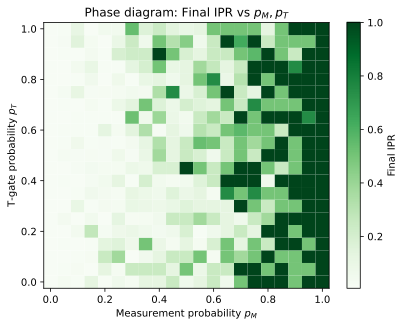

  - Number of qubits (L): 8
  - IPR calculated at circuit depth (D) of: 18 layers
  - Runs averaged over: 1


In [54]:
pM_vals = sorted({k[0] for k in iprs_final_dict})
pT_vals = sorted({k[1] for k in iprs_final_dict})

heatmap = np.full((len(pT_vals), len(pM_vals)), np.nan)

for (pT, pM), ipr_final in iprs_final_dict.items():
    i = pT_vals.index(pM)
    j = pM_vals.index(pT)
    heatmap[i, j] = ipr_final

X, Y = np.meshgrid(pM_vals, pT_vals)
plt.pcolormesh(X, Y, heatmap, shading='auto', cmap='Greens')
plt.colorbar(label="Final IPR")
plt.ylabel("T-gate probability $p_T$")
plt.xlabel("Measurement probability $p_M$")
plt.title("Phase diagram: Final IPR vs $p_M, p_T$")
plt.show()

print(f"  - Number of qubits (L): {L}")
print(f"  - IPR calculated at circuit depth (D) of: {D} layers")
print(f"  - Runs averaged over: {n_runs}")

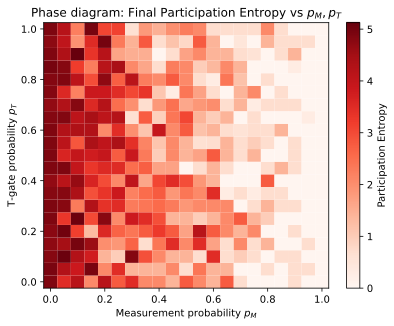

  - Number of qubits (L): 8
  - Participation entropy calculated at circuit depth (D) of: 18 layers
  - Runs averaged over: 1


In [55]:
# --- Participation Entropy heatmap (from IPR) ---

pM_vals = sorted({k[0] for k in iprs_final_dict})
pT_vals = sorted({k[1] for k in iprs_final_dict})

heatmap_S = np.full((len(pT_vals), len(pM_vals)), np.nan)

for (pM, pT), ipr_final in iprs_final_dict.items():
    i = pM_vals.index(pM)
    j = pT_vals.index(pT)
    heatmap_S[j, i] = -np.log(ipr_final)  # S = -log(IPR)

X, Y = np.meshgrid(pM_vals, pT_vals)
plt.pcolormesh(X, Y, heatmap_S, shading='auto', cmap='Reds')
plt.colorbar(label="Participation Entropy")
plt.ylabel("T-gate probability $p_T$")
plt.xlabel("Measurement probability $p_M$")
plt.title("Phase diagram: Final Participation Entropy vs $p_M, p_T$")
plt.show()

print(f"  - Number of qubits (L): {L}")
print(f"  - Participation entropy calculated at circuit depth (D) of: {D} layers")
print(f"  - Runs averaged over: {n_runs}")